In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from _utils import get_data_dir

DATA_DIR = get_data_dir()
ROOT = get_data_dir()

In [2]:
conds = ["100_0", "80_20", "50_50"]

bio_dfs = []

def df_to_pdf(df, filename):
    df = df.round(3)
    fig, ax = plt.subplots(figsize=(12, len(df)*0.4 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    with PdfPages(filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')

for cond in conds:
    base = ROOT / cond
    
    # Use the angle-estimation file: one row per trial → one full iteration
    g = pd.read_csv(base / "angle_estimations" / "gemini-2.5-pro.csv")
    
    # Build BIO scaffolding
    g["stimID"] = g["image_id"]
    g["condition"] = cond
    g["participantID"] = "BIO"
    
    # Placeholder response column for BIO (no decisions yet)
    g["response"] = np.nan

    # Keep columns analogous to model_master, but **without** the 'decision' column
    bio_dfs.append(
        g[[
            "stimID",
            "condition",
            "side_selected",
            "cue_points",
            "line1_angle",
            "line2_angle",
            "valid_cue",
            "TP",
            "response",
            "participantID",
        ]]
    )

BIO_master = pd.concat(bio_dfs, ignore_index=True)

display(BIO_master)

,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID
0,100,100_0,1,1,14.314827,1.921956,True,True,NaN,BIO
1,845,100_0,1,1,15.054317,4.222230,True,True,NaN,BIO
2,245,100_0,1,1,14.314827,6.508956,True,True,NaN,BIO
3,72,100_0,2,2,8.775056,15.054317,True,True,NaN,BIO
4,469,100_0,2,2,4.222230,19.885165,True,True,NaN,BIO
...,...,...,...,...,...,...,...,...,...,...
2995,698,50_50,1,2,11.159944,6.508956,False,False,NaN,BIO
2996,910,50_50,1,1,9.651833,4.986334,True,False,NaN,BIO
2997,880,50_50,2,2,4.222230,8.775056,True,False,NaN,BIO
2998,53,50_50,2,2,4.986334,11.908300,True,False,NaN,BIO


In [3]:
class BayesianIdealObserver:
    """
    Bayesian Ideal Observer (BIO) for the 2AFC target-detection task with a spatial cue.

    Assumptions (per trial):
      - Two angles: line1_angle (left), line2_angle (right).
      - Target-present TP=1 vs target-absent TP=0.
      - TP=0: both angles ~ N(mu_noise, sigma^2), cue random (0.5 left/right).
      - TP=1: one side S∈{1,2} is target side, chosen with prob 0.5.
              x_S     ~ N(mu_target, sigma^2)
              x_other ~ N(mu_noise, sigma^2)
              cue points to S with prob v (cue validity), otherwise to other side.
      - Condition determines validity v:
            50_50 -> 0.5
            80_20 -> 0.8
            100_0 -> 1.0
      - Prior P(TP=1) = prior_tp (default 0.5).

    This class:
      * Adds BIO columns (likelihood ratio, log LR, posterior, decisions) to a DataFrame.
      * Computes SDT metrics (accuracy, hit rate, fa rate, d', criterion) by condition.
    """

    def __init__(
        self,
        mu_target: float = 15.0,
        mu_noise: float = 5.0,
        sigma: float = 3.5,
        prior_tp: float = 0.5,
        cond_validity: dict | None = None,
    ):
        """
        Parameters
        ----------
        mu_target : float
            Mean angle for the target distribution.
        mu_noise : float
            Mean angle for the noise distribution.
        sigma : float or None
            Sensory noise standard deviation. If None, it will be estimated
            from TP=0 trials of whatever DataFrame you pass to add_bio_columns.
        prior_tp : float
            Prior probability P(TP=1).
        cond_validity : dict or None
            Mapping from condition label -> cue validity v.
            If None, defaults to: {"50_50": 0.5, "80_20": 0.8, "100_0": 1.0}.
        """
        self.mu_target = mu_target
        self.mu_noise = mu_noise
        self.sigma = sigma
        self.prior_tp = prior_tp

        if cond_validity is None:
            cond_validity = {
                "50_50": 0.5,
                "80_20": 0.8,
                "100_0": 1.0,
            }
        self.cond_validity = cond_validity

    # ---------------------------------------------------------
    # Main method: add BIO columns to a DataFrame
    # ---------------------------------------------------------
    def add_bio_columns(
        self,
        df: pd.DataFrame,
        line1_col: str = "line1_angle",
        line2_col: str = "line2_angle",
        cue_col: str = "cue_points",
        cond_col: str = "condition",
        tp_col: str = "TP",
    ) -> pd.DataFrame:
        """
        Return a copy of df with the following added columns:

          - bio_sigma      : sigma used by the BIO
          - bio_lambda     : likelihood ratio Λ = p(x,c|TP=1)/p(x,c|TP=0)
          - bio_llr        : log(Λ)
          - bio_p_present  : posterior P(TP=1 | x1,x2,c,cond)
          - bio_decision   : 1 if BIO says "target present", else 0
        """

        out = df.copy()

        # 1. Decide sigma
        sigma = float(self.sigma)
        out["bio_sigma"] = sigma

        # 2. Extract angles, cue, condition
        x1 = out[line1_col].to_numpy()
        x2 = out[line2_col].to_numpy()
        cue = out[cue_col].to_numpy()  # 1 = left, 2 = right
        # map each condition to its validity v
        v = out[cond_col].map(self.cond_validity).to_numpy()

        # 3. Angle evidence: R(x) = N(x; mu_target,σ²) / N(x; mu_noise,σ²)
        #    Using the closed-form ratio for equal-variance Gaussians.
        delta_mu = self.mu_target - self.mu_noise
        offset = (self.mu_target**2 - self.mu_noise**2) / 2.0
        denom = sigma**2

        R1 = np.exp((delta_mu * x1 - offset) / denom)
        R2 = np.exp((delta_mu * x2 - offset) / denom)

        # 4. Cue likelihoods given target side
        #    For each trial:
        #      p(cue | S=1) = v if cue==1 else 1-v
        #      p(cue | S=2) = v if cue==2 else 1-v
        p_c_given_S1 = np.where(cue == 1, v, 1.0 - v)
        p_c_given_S2 = np.where(cue == 2, v, 1.0 - v)

        # 5. Likelihood ratio Λ(x1,x2,c,cond)
        #    Λ = R1 * p(c|S=1) + R2 * p(c|S=2)
        Lambda = R1 * p_c_given_S1 + R2 * p_c_given_S2

        # Numerical safety
        eps = 1e-12
        Lambda_safe = np.maximum(Lambda, eps)
        log_Lambda = np.log(Lambda_safe)

        out["bio_lambda"] = Lambda_safe
        out["bio_llr"] = log_Lambda

        # 6. Posterior with prior P(TP=1) = prior_tp
        # Posterior odds = Λ * prior_odds
        # P(TP=1 | data) = odds / (1 + odds)
        prior_tp = np.clip(self.prior_tp, 1e-6, 1 - 1e-6)
        prior_odds = prior_tp / (1.0 - prior_tp)

        log_posterior_odds = log_Lambda + np.log(prior_odds)
        posterior_odds = np.exp(log_posterior_odds)
        p_present = posterior_odds / (1.0 + posterior_odds)

        out["bio_p_present"] = p_present

        # 7. Bayes-optimal decision: TP=1 iff posterior odds > 1
        out["bio_decision"] = (log_posterior_odds > 0).astype(int)

        return out

    # ---------------------------------------------------------
    # SDT metrics
    # ---------------------------------------------------------
    @staticmethod
    def _compute_sdt_metrics(
        df: pd.DataFrame,
        decision_col: str = "bio_decision",
        tp_col: str = "TP",
    ) -> pd.Series:
        n_trials = len(df)
        n_signal = (df[tp_col] == 1).sum()
        n_noise = (df[tp_col] == 0).sum()

        hits = ((df[tp_col] == 1) & (df[decision_col] == 1)).sum()
        fas = ((df[tp_col] == 0) & (df[decision_col] == 1)).sum()
        crs = ((df[tp_col] == 0) & (df[decision_col] == 0)).sum()

        accuracy = (hits + crs) / n_trials if n_trials > 0 else np.nan

        # log-linear correction for extreme rates
        H = (hits + 0.5) / (n_signal + 1) if n_signal > 0 else np.nan
        F = (fas + 0.5) / (n_noise + 1) if n_noise > 0 else np.nan

        if np.isfinite(H) and np.isfinite(F):
            zH = norm.ppf(H)
            zF = norm.ppf(F)
            dprime = zH - zF
            criterion = -0.5 * (zH + zF)
        else:
            dprime = np.nan
            criterion = np.nan

        return pd.Series(
            {
                "n_trials": n_trials,
                "accuracy": accuracy,
                "hit_rate": H,
                "fa_rate": F,
                "dprime": dprime,
                "criterion": criterion,
            }
        )

    def compute_sdt_by_condition(
        self,
        df: pd.DataFrame,
        condition_col: str = "condition",
        decision_col: str = "bio_decision",
        tp_col: str = "TP",
    ) -> pd.DataFrame:
        """
        Group df by condition and compute SDT metrics for the BIO decisions.
        Returns a DataFrame with one row per condition.
        """
        grouped = (
            df.groupby(condition_col, as_index=False)
            .apply(lambda sub: self._compute_sdt_metrics(sub, decision_col, tp_col))
        )
        # groupby-apply with as_index=False returns condition_col as index; reset nicely:
        metrics = grouped.reset_index(drop=True)
        metrics.rename(columns={condition_col: "condition"}, inplace=True)
        metrics["who"] = "BIO"
        return metrics


C:\Users\AdamR\AppData\Local\Temp\ipykernel_9556\3252828682.py:197: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda sub: self._compute_sdt_metrics(sub, decision_col, tp_col))


,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion,who
0,100_0,1000.0,0.920,0.931138,0.092814,2.807940,-0.080348,BIO
1,50_50,1000.0,0.886,0.895210,0.124750,2.406281,-0.051578,BIO
2,80_20,1000.0,0.886,0.897206,0.126747,2.407695,-0.061941,BIO


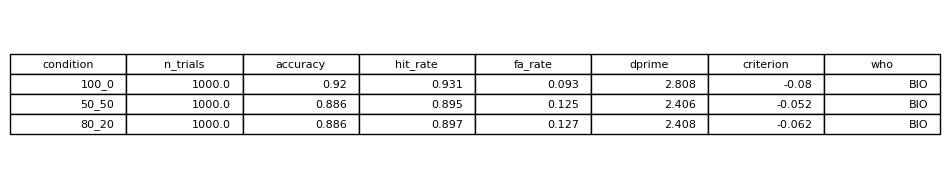

In [ ]:
#Bio Metrics
bio = BayesianIdealObserver(
    mu_target=15.0,
    mu_noise=5.0,
    sigma=3.5,   # or None to estimate from TP=0
    prior_tp=0.5
)

bio_with_decisions = bio.add_bio_columns(BIO_master)

BIO_metrics = bio.compute_sdt_by_condition(bio_with_decisions)
display(BIO_metrics)

df_to_pdf(BIO_metrics, "outputs/BIO_metrics_table.pdf")

In [5]:
#Misses and False Alarms Analysis
df = bio_with_decisions.copy()

# -----------------------------------------------------------
# 1. Label outcomes
# -----------------------------------------------------------
def classify_outcome(tp, dec):
    if tp == 1 and dec == 1:
        return "hit"
    elif tp == 1 and dec == 0:
        return "miss"
    elif tp == 0 and dec == 1:
        return "false_alarm"
    elif tp == 0 and dec == 0:
        return "correct_reject"
    return "other"

df["bio_outcome"] = [
    classify_outcome(tp, dec)
    for tp, dec in zip(df["TP"], df["bio_decision"])
]

# -----------------------------------------------------------
# 2. Canonicalize TP=1 trials: target vs nontarget frame
#    requires 'side_selected' (1=left, 2=right)
# -----------------------------------------------------------
if "side_selected" in df.columns:
    tp1 = df[df["TP"] == 1].copy()

    is_target_left = (tp1["side_selected"] == 1)

    # put the target side into "target_angle", other side into "nontarget_angle"
    tp1["target_angle"] = np.where(is_target_left, tp1["line1_angle"], tp1["line2_angle"])
    tp1["nontarget_angle"] = np.where(is_target_left, tp1["line2_angle"], tp1["line1_angle"])

    # cue_to_target: did the cue point to the true target side?
    tp1["cue_to_target"] = np.where(
        (is_target_left & (tp1["cue_points"] == 1)) |
        (~is_target_left & (tp1["cue_points"] == 2)),
        1, 0
    )

    # sensory difference in a target-centered frame
    tp1["sensory_diff"] = tp1["target_angle"] - tp1["nontarget_angle"]

    # focus on misses only
    tp1_miss = tp1[tp1["bio_outcome"] == "miss"]

    miss_summary = (
        tp1_miss
        .groupby("condition")
        .agg(
            n_miss=("bio_outcome", "size"),
            mean_target=("target_angle", "mean"),
            mean_nontarget=("nontarget_angle", "mean"),
            mean_sensory_diff=("sensory_diff", "mean"),
            prop_cue_to_target=("cue_to_target", "mean"),
            mean_p_present=("bio_p_present", "mean"),
        )
        .reset_index()
    )

    print("=== Misses (TP=1) summarized in target-centered frame ===")
    display(miss_summary)
else:
    print("No 'side_selected' column found; skipping target-centered analysis for TP=1.")

# -----------------------------------------------------------
# 3. Canonicalize TP=0 trials: cue vs noncue frame
# -----------------------------------------------------------
tp0 = df[df["TP"] == 0].copy()

# put the cued side into "cue_angle" and the other side into "noncue_angle"
tp0["cue_angle"] = np.where(tp0["cue_points"] == 1,
                            tp0["line1_angle"], tp0["line2_angle"])
tp0["noncue_angle"] = np.where(tp0["cue_points"] == 1,
                               tp0["line2_angle"], tp0["line1_angle"])

tp0["angle_diff"] = tp0["cue_angle"] - tp0["noncue_angle"]

# focus on false alarms
tp0_fa = tp0[tp0["bio_outcome"] == "false_alarm"]

fa_summary = (
    tp0_fa
    .groupby("condition")
    .agg(
        n_fa=("bio_outcome", "size"),
        mean_cue_angle=("cue_angle", "mean"),
        mean_noncue_angle=("noncue_angle", "mean"),
        mean_angle_diff=("angle_diff", "mean"),
        mean_p_present=("bio_p_present", "mean"),
    )
    .reset_index()
)

print("\n=== False alarms (TP=0) summarized in cue-centered frame ===")
display(fa_summary)

# Optionally: keep df with outcome + canonical info for further plotting
df.head()


=== Misses (TP=1) summarized in target-centered frame ===


,condition,n_miss,mean_target,mean_nontarget,mean_sensory_diff,prop_cue_to_target,mean_p_present
0,100_0,34,8.281056,4.978832,3.302224,1.000000,0.245194
1,50_50,52,9.046278,4.108333,4.937945,0.557692,0.263498
2,80_20,51,9.358217,4.511819,4.846398,0.529412,0.265107



=== False alarms (TP=0) summarized in cue-centered frame ===


,condition,n_fa,mean_cue_angle,mean_noncue_angle,mean_angle_diff,mean_p_present
0,100_0,46,11.565631,5.098803,6.466828,0.737163
1,50_50,62,7.709852,9.359590,-1.649738,0.699078
2,80_20,63,10.597566,6.145411,4.452155,0.694765


,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,bio_sigma,bio_lambda,bio_llr,bio_p_present,bio_decision,bio_outcome
0,100,100_0,1,1,14.314827,1.921956,True,True,NaN,BIO,3.5,33.862482,3.522308,0.971316,1,hit
1,845,100_0,1,1,15.054317,4.222230,True,True,NaN,BIO,3.5,61.928017,4.125973,0.984109,1,hit
2,245,100_0,1,1,14.314827,6.508956,True,True,NaN,BIO,3.5,33.862482,3.522308,0.971316,1,hit
3,72,100_0,2,2,8.775056,15.054317,True,True,NaN,BIO,3.5,61.928017,4.125973,0.984109,1,hit
4,469,100_0,2,2,4.222230,19.885165,True,True,NaN,BIO,3.5,3195.575711,8.069523,0.999687,1,hit
